# Step 1: Calibration of camera intrinsic values

In [23]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
from itertools import count

In [24]:
CAMERA_ID = 'david'
SESSION_ID = '13-04-2021b'
PROCESSED_IMAGE_NAME = 'result_247_247_4_7.png'
CHESSBOARD_SQUARE_LENGTH_MM = 1
CHESSBOARD_DIMENSIONS = (9,6)
CAPTURE_DEVICE = 0
EXTRINSIC_CALIBRATION_FRAME_COUNT = 120
PLANE_CALIBRATION_OBJECT_HEIGHT = 2

## Chessboard calibration (intrisinc parameters)

In [25]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
sample_object_points = np.zeros((CHESSBOARD_DIMENSIONS[0] * CHESSBOARD_DIMENSIONS[1],3), np.float32)

# TODO: check if this is the correct way to adjust the sizes. Used this accordint to: https://stackoverflow.com/questions/37310210/camera-calibration-with-opencv-how-to-adjust-chessboard-square-size
sample_object_points[:,:2] = np.mgrid[0:CHESSBOARD_DIMENSIONS[0],0:CHESSBOARD_DIMENSIONS[1]].T.reshape(-1,2) * CHESSBOARD_SQUARE_LENGTH_MM

# Swap axis so that the z axis is perpendicular to the chessboard
sample_object_points[:, [1, 0]] = sample_object_points[:, [0, 1]]

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

images = glob.glob(f'data/calibration/{CAMERA_ID}/intrinsic/*.png')
print(f'Found {len(images)} calibration images')

for fname in images:
    image = cv2.imread(fname)
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.append(sample_object_points)

        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.append(improved_corners)
    else:
        print(f'Could not find chessboard corners in image {fname}')


Found 20 calibration images


### Intrinsic Parameters

In [26]:
ret, intrinsic_matrix, distortion_coefs, rotation_vecs, translation_vecs = cv2.calibrateCamera(object_points, image_points, grayscale_image.shape[::-1],None,None)
print('Image Dimensions')
print(grayscale_image.shape)
print('Intrinsic Matrix')
print(intrinsic_matrix)
print('Distortion Coefficients')
print(distortion_coefs)
print('Rotation Vectors')
print(rotation_vecs)
print('Translation Vectors')
print(translation_vecs)

Image Dimensions
(720, 1280)
Intrinsic Matrix
[[9.95501374e+02 0.00000000e+00 6.59362830e+02]
 [0.00000000e+00 1.00107125e+03 3.60433162e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients
[[ 0.27103847 -0.58181555 -0.02118469  0.00707566  0.56085949]]
Rotation Vectors
[array([[ 2.08127707],
       [-2.09044261],
       [ 0.27168127]]), array([[ 1.65084257],
       [ 2.41501087],
       [-0.23927253]]), array([[ 0.04104214],
       [ 2.9664063 ],
       [-0.37563987]]), array([[-0.04790192],
       [ 3.0160093 ],
       [-0.36130581]]), array([[ 1.04977134],
       [ 2.77734585],
       [-0.29010723]]), array([[ 2.9204664 ],
       [-0.02701965],
       [ 0.03010079]]), array([[ 2.2521635 ],
       [ 1.76332135],
       [-0.11722763]]), array([[ 2.64616978],
       [ 1.08315951],
       [-0.05119949]]), array([[-0.12313616],
       [ 3.05119573],
       [-0.27007403]]), array([[-0.78736026],
       [ 2.9573973 ],
       [-0.3248312 ]]), array([[2.74664385],
  

### Intrinsic Reprojection Error

In [27]:
def calculate_reprojection_error(objpoints, imgpoints, rvecs, tvecs, imatrix, distortion):
    mean_error = 0
    for i in range(len(objpoints)):
        calculted_image_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], imatrix, distortion)
        error = cv2.norm(imgpoints[i], calculted_image_points, cv2.NORM_L2)/len(calculted_image_points)
        mean_error += error

    return mean_error/len(objpoints)

In [28]:
print(f'Reprojection error: {calculate_reprojection_error(object_points, image_points, rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)}')

Reprojection error: 0.049253993638239124


## Chessboard calibration (extrinsic parameters)

In [29]:
'''
EXTRINSIC PARAMETERS
'''

# Arrays to store object points and image points from all the images.
object_points = [] # 3d point in real world space
image_points = [] # 2d points in image plane.

images = glob.glob(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/extrinsic/*.png')
print(f'Found {len(images)} calibration images')

for fname in images:
    image = cv2.imread(fname)
    grayscale_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayscale_image, CHESSBOARD_DIMENSIONS, None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        object_points.extend(list(sample_object_points))
        improved_corners = cv2.cornerSubPix(grayscale_image, corners, (11,11), (-1,-1), criteria)
        image_points.extend(list(improved_corners))
    else:
        print(f'Could not find chessboard corners in {fname}')

object_points = np.float64(object_points)
image_points = np.float64(image_points)
print(object_points.shape)
print(image_points.shape)
  

Found 20 calibration images
(1080, 3)
(1080, 1, 2)


In [57]:
ret, rotation_vecs, translation_vecs, _ = cv2.solvePnPRansac(object_points, image_points, intrinsic_matrix, distortion_coefs)
print(rotation_vecs)

[[ 1.88219278]
 [ 1.68438173]
 [-0.52647774]]


### Extrinsic Reprojection Error

In [31]:
mean_error = 0

for i in range(len(object_points)):
    calulated_image_points, _ = cv2.projectPoints(object_points[i], rotation_vecs, translation_vecs, intrinsic_matrix, distortion_coefs)
    error = cv2.norm(image_points[i],calulated_image_points[0], cv2.NORM_L2)/len(calulated_image_points)
    mean_error += error

print(f'Reprojection error: {mean_error/len(object_points)}')

Reprojection error: 5.023792816689773


## Projection Calculation

In [32]:
rotation_matrix = cv2.Rodrigues(rotation_vecs)[0]
extrinsic_matrix = np.concatenate((rotation_matrix, translation_vecs), axis=1)
perspective_projection_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
perspective_projection_matrix

array([[-2.74865362e+02,  1.07748960e+03, -4.35025881e+02,
         8.03258018e+03],
       [ 5.47192427e+02, -8.24106524e+00, -9.12451775e+02,
         1.27263121e+04],
       [-6.22453789e-01,  1.42444549e-01, -7.69584844e-01,
         4.38542803e+01]])

In [33]:
def get_xyz_coords(i, j, ppm, constraints = None):
    k1 = ppm[2] * i
    k2 = ppm[2] * j
    k3 = k1 - ppm[0]
    k4 = k2 - ppm[1]
    a = [k3[0:-1], k4[0:-1]]
    b = [-k3[-1], -k4[-1]]

    for constraint in constraints:
        a.append(np.array(constraint[0:-1]))
        b.append(np.array(constraint[-1]))
    res = np.linalg.solve(a, b)

    return res

## Shadow/Light Plane Calibration

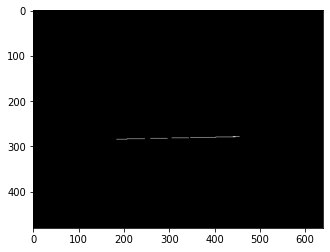

In [34]:
TEMP_SESSION = '13-04-2021b'
flat_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/frame_2021-04-13 21:39:34.254860.png',cv2.IMREAD_GRAYSCALE)
height_image = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_height/intrujice.png', cv2.IMREAD_GRAYSCALE)
processed_bottom = cv2.imread(f'data/calibration/{CAMERA_ID}/{TEMP_SESSION}/shadow_flat/result_231_233_5_8-clean-clean.png', cv2.IMREAD_GRAYSCALE)
top_lines = cv2.subtract(height_image, processed_bottom)
ret, processed_top = cv2.threshold(top_lines, 240, 255, cv2.THRESH_BINARY)

processed_bottom = processed_bottom
processed_top = height_image
plt.imshow(processed_bottom, cmap='gray')

In [51]:
shadow_plane_3d_points = []

# 'Floor' points
white_pixel_coords = cv2.findNonZero(processed_bottom)
for pixel in white_pixel_coords:
    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1,0]])
    shadow_plane_3d_points.append(point)

# Object top points
white_pixel_coords = cv2.findNonZero(processed_top)
for pixel in white_pixel_coords:

    point = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [[0,0,1, PLANE_CALIBRATION_OBJECT_HEIGHT]])
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)
    shadow_plane_3d_points.append(point)

In [52]:
# Calculate A,B,C and D parameters of the light/shadow plane using least squares method
plane_points = np.hstack((shadow_plane_3d_points, np.ones((len(shadow_plane_3d_points), 1)) * -1))
res = np.linalg.lstsq(plane_points, np.zeros((len(plane_points))), rcond=None)
print(res)

(array([0., 0., 0., 0.]), array([0.]), 4, array([148.6064371 ,  41.12187449,   8.26970177,   0.43436865]))


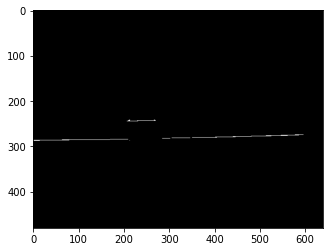

In [45]:
shadow_points = cv2.imread(f'data/calibration/{CAMERA_ID}/{SESSION_ID}/cube_processed/{PROCESSED_IMAGE_NAME}')
shadow_points_gray = cv2.cvtColor(shadow_points, cv2.COLOR_BGR2GRAY)
#plt.xticks([]), plt.yticks([])
plt.imshow(shadow_points, cmap='gray')

In [53]:
# Calculate y and z for points in shadow
points_y = []
points_z = []
points_x = []
white_pixel_coords = cv2.findNonZero(shadow_points_gray)
for pixel in white_pixel_coords:
    x, y, z = get_xyz_coords(pixel[0,0],pixel[0,1], perspective_projection_matrix, [list(res[3])])
    points_y.append(y)
    points_z.append(z)
    points_x.append(x)


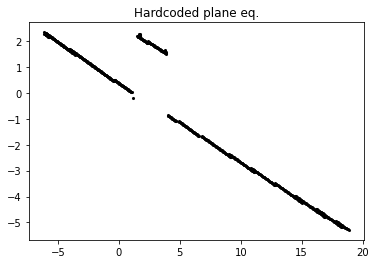

In [54]:
figure, subplots = plt.subplots(1)
points = []
subplots.set_title('Original')
subplots.scatter(points_y, points_z, color='black', marker='.', linewidths=0.1)
#plt.xlim([-5,9])
#plt.ylim([-3,3])
plt.title('Hardcoded plane eq.')
plt.show()

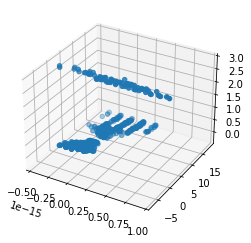

In [40]:
fig = plt.figure()

# syntax for 3-D projection
ax = plt.axes(projection ='3d')

  
# defining axes
ax.scatter(points_x, points_y, points_z)
#for ii in range(0,360,1):
#        ax.view_init(elev=10., azim=ii)
#        plt.savefig("movie/movie%d.png" % ii)



In [41]:
from sklearn.linear_model import RANSACRegressor, LinearRegression
plane_points = np.hstack((shadow_plane_3d_points, np.ones((len(shadow_plane_3d_points), 1)) * -1))
reg = RANSACRegressor(base_estimator=LinearRegression(fit_intercept=True), residual_threshold=0.1).fit(plane_points, np.zeros((len(plane_points))))
reg.estimator_.coef_

array([0., 0., 0., 0.])

In [42]:
reg.get_params()

{'base_estimator__copy_X': True,
 'base_estimator__fit_intercept': True,
 'base_estimator__n_jobs': None,
 'base_estimator__normalize': False,
 'base_estimator__positive': False,
 'base_estimator': LinearRegression(),
 'is_data_valid': None,
 'is_model_valid': None,
 'loss': 'absolute_loss',
 'max_skips': inf,
 'max_trials': 100,
 'min_samples': None,
 'random_state': None,
 'residual_threshold': 0.1,
 'stop_n_inliers': inf,
 'stop_probability': 0.99,
 'stop_score': inf}

array([0., 0., 0., 0.])